# PPCA and MuVi
Let's recall that PPCA is defined as
$$y|z\sim N(Wz,\sigma^2I_n)$$
$$z\sim N(0,I_d)$$
$$w_{jk}\sim N(0,1)$$
$$\sigma^2\sim \text{InverseGamma}(1,1)$$
where $n$ is the dimension of the original data and $d$ is the reduced dimension of the factors, for unknown $W\in R^{n\times d}$ and $\sigma>0$.

## True MLE
We know ([Bishop](https://www.robots.ox.ac.uk/~cvrg/hilary2006/ppca.pdf)) that the MLE of each is:
$$ \hat{W}_{MLE} = U_d (\Lambda_d - \sigma^2I_d)^{1/2}$$
where the $d$ column vectors in the $n\times d$ matrix $U_d$ are the principal eigenvectors of the observed covariance matrix $S= \frac1N\sum y_iy_i'$, with corresponding eigenvalues $\lambda_1,...,\lambda_q$ in the $d\times d$ diagonal matrix $\Lambda_d$, and
$$ \hat{\sigma}_{MLE}^2 = \frac{\sum_{j={d+1}}^n \lambda_j}{n-d}$$

However, we will find numerical estimates with two methods.
## Posterior mean (variational inference)

### Approximate posteriors
We can use variational inference to compute the $\hat W,\hat \sigma^2$ as the mean of the posterior. We aim to compute the posterior $p(W,\sigma,z|y)$, but it is difficult to find, so we approximate the posteriors with:
$$q(W)= N(\mu_W,\sigma^2_W)$$
$$q(\sigma)=\text{LogNormal}(\mu_\sigma,\sigma^2_\sigma)$$
$$q(z)=N(\mu_z,\sigma^2_z)$$
where we need to learn the best $\{\mu_*,\sigma_*\},*\in\{W,z,\sigma\}$.

### Maximize ELBO
To achieve that, we minimize the -ELBO:
$$-ELBO = \mathbb{E}_{Z\sim q}NLL(y|z) + KL(q(Z),p(Z)) + KL(q(W),p(W)) + KL(q(\sigma^2),p(\sigma^2))$$
where $KL(q,p) = E_{Z\sim q}(\log q(Z) - \log p(Z))$.

Note that the first and second KL have closed expressions, and but the NLL and the $KL(q(\sigma),p(\sigma))$ need to be approximated with Monte Carlo samples. To compute the gradient on the parameters that appear in the sampling, we have to employ the reparametrization trick:
$$
\begin{split}
\mathbb{E}_{Z\sim q} NLL(y|z;W,\sigma^2) &= \mathbb{E}_{\varepsilon\sim N(0,1)}NLL(y|\mu_z+\sigma_z\varepsilon;W,\sigma^2)\\
&\approx \frac1M\sum_{i=1}^M \frac{1}{2\sigma^2}||y-W(\mu_z+\sigma_z\varepsilon_i)||^2+\frac{n}{2}\log(2\pi\sigma^2)
\end{split}
$$
and now we can compute the gradients and find best $\mu_z,\sigma_z$ iteratively. Similarly, with 
$$
\begin{split}
KL(q(\sigma^2),p(\sigma^2)) &= E_{q(\sigma^2)}(\log q(\sigma^2)-\log p(\sigma^2))\\
&\approx \frac1M\sum_{i=1}^M\log q(\sigma_i^2)-\log p(\sigma_i^2), \text{ where }\sigma_i^2 = \exp(\mu_\sigma+\sigma_\sigma\varepsilon_i),\varepsilon_i\sim N(0,1)
\end{split}
$$
In that way we can iteratively use gradient-descent-based algorithms to minimize the -ELBO and find the best $\{\mu_*,\sigma_*\}$.

### Approximate Posterior Mean as Estimator
Finally, we estimate the parameters with the mean of the approximate posteriors:
$$\hat W = \mu_W,\,\hat z = \mu_z, \hat \sigma^2 = \mu_\sigma$$

## Maximum a posteriori (optimization)

Another entirely different approach is estimating the parameters with the value that maximized the posterior distribution:
$$\hat W, \hat \sigma^2, \hat z = \argmax \log p(W,\sigma^2,z|y) = \argmax \log p(y|W,\sigma^2,z)+\log p(W)+\log p(z)+\log p(\sigma^2)$$
where each of these terms can be computed analytically and we're able to find their gradients. So we can directly optimize this objective function using gradient-descent methods.
## Comparison MAP vs VI
**MAP Estimation**:
* Provides point estimates of the parameters (single best guess).
* Optimizes the posterior directly by maximizing it.
* Simpler to implement, since it reduces to an optimization problem, without the need to handle variational distributions.
* May be faster than variational inference because it avoids sampling.
* Lacks Uncertainty Quantification: Does not provide information about the uncertainty of the estimates. ($\{\sigma_*\}$)

**Variational Inference**:
* Approximates the entire posterior distribution with a simpler distribution $q$
* Optimizes the parameters of $q$ to minimize the KL divergence to the true posterior.
* Provides uncertainty estimates via the variational distributions.

## Connection to MuVi
MuVi proposes a very similar model with two important changes:
1. Shrinks the variance of $w_{jk}\sim N(0,(\tau\delta_k\lambda_{jk})^2)$, where $\tau,\delta_k,\lambda_{jk}\sim Cauchy^+(c), c = 1$. 
2. Uses variantional approach during the optimization but estimates the parameters as the posterior mode instead of the posterior mean.

# Setup and utilities

In [1]:
from ppca.model import PPCA_VI,PPCA_MAP
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from MuVI import muvi as muvi_2
import torch
from matplotlib import pyplot as plt
import statsmodels.api as sm
import pandas as pd

import logging

# Disable all logging messages
logging.disable(logging.CRITICAL)
device = "cpu"
try:
    device = f"cuda:{muvi_2.get_free_gpu_idx()}"
    print(device)
except Exception as e:
    print(e)

/scratch/users/max_medina/conda/envs/muvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
# Step 1: Generate synthetic data
def generate_ppca_data(n_samples, data_dim, latent_dim, noise_std):
    """
    Generate synthetic data for PPCA.

    Args:
        n_samples (int): Number of data points.
        data_dim (int): Dimensionality of the observed data.
        latent_dim (int): Dimensionality of the latent space.
        noise_std (float): Standard deviation of noise.

    Returns:
        torch.Tensor: Synthetic data matrix (n_samples x data_dim).
    """
    torch.manual_seed(2)  # For reproducibility

    # Generate true latent variables
    Z = torch.randn(n_samples, latent_dim)
    # Generate true loading matrix W
    W_true = torch.randn(data_dim, latent_dim)
    # Generate observed data
    Y = Z @ W_true.T + noise_std * torch.randn(n_samples, data_dim)
    return Y, W_true, Z

In [3]:
# Init PPCA model
def ppca_analysis(ppca_model, n_components, data, W_true, Z, lr, num_steps):
    ppca = ppca_model(n_components=n_components, data_dim=data_dim)
    # Fit the model
    losses = ppca.fit(data,num_steps=num_steps,lr=lr)
    
    fig,ax = plt.subplots(1,4,figsize=(16,3))
    ax[0].plot(np.arange(len(losses)),losses)
    ax[0].set_title(f'Loss after {num_steps} epochs')
    # plt.show()

    # Analyze the results
    # Transform the data to the latent space
    Z_learned = ppca.transform(data)

    # Reconstruct the data from the latent representation
    data_proj = ppca.reconstruct(Z_learned)

    # Retrieve learned parameters
    parameters = ppca.get_parameters()
    W_learned,std_learned = parameters["W"],parameters["noise_variance"]

    # Step 4: Visualize the results
    # Plot the true vs. reconstructed data for the first feature
    ax[1].scatter(data[:, 0].detach().numpy(), data_proj[:, 0].detach().numpy(), alpha=0.6,label='first')
    ax[1].scatter(data[:, 1].detach().numpy(), data_proj[:, 1].detach().numpy(), alpha=0.6,label='second')
    ax[1].axline((0, 0), slope=1, color='r')
    ax[1].legend()
    ax[1].set_xlabel("True")
    ax[1].set_ylabel("Reconstructed")
    ax[1].set_title("Data")

    # Compare true and learned loading matrices
    ax[2].scatter(W_true[:, 0].detach().numpy(), W_learned[:, 0].detach().numpy(), alpha=0.6,label='first')
    ax[2].scatter(W_true[:, 1].detach().numpy(), W_learned[:, 1].detach().numpy(), alpha=0.6,label='second')
    ax[2].legend()
    ax[2].axline((0, 0), slope=1, color='r')
    ax[2].set_xlabel("True")
    ax[2].set_ylabel("Reconstructed")
    ax[2].set_title(f"Ws. Sigma={round(std_learned.item(),3)}")
    
    # compare hidden variables
    ax[3].scatter(Z[:, 0].detach().numpy(), Z_learned[:, 0].detach().numpy(), alpha=0.6,label='first')
    ax[3].scatter(Z[:, 1].detach().numpy(), Z_learned[:, 1].detach().numpy(), alpha=0.6,label='second')
    ax[3].legend()
    ax[3].axline((0, 0), slope=1, color='r')
    ax[3].set_xlabel("True")
    ax[3].set_ylabel("Reconstructed")
    ax[3].set_title("Zs")
    plt.show()
    return W_learned.detach().numpy(),Z_learned.detach().numpy(),data_proj.detach().numpy()

def generate_data(size,taus,sigma):
    """
    generate matrix with concatenation of [N(tau,sigma) for tau in tau] for given size
    """
    cells,genes = size
    fn = np.random.normal # change to other distribution
    data = []
    sigma = sigma if isinstance(sigma,list) else np.repeat(sigma,len(taus))
    for i,tau in enumerate(taus):
        data.append(fn(loc=tau,scale = sigma[i],size=(cells,genes)))
    data = np.concatenate(data,axis = 0)
    # create labels TODO: one-hot encode them
    labels = np.repeat(np.arange(len(taus)), cells)
    return torch.from_numpy(data),torch.from_numpy(labels)

def addlabels(x,y):
    """
    function to add value labels in barplot
    """
    decimals = 3
    for i in range(len(x)):
        plt.text(i, round(y[i],decimals)+0.01, round(y[i],decimals), ha = 'center')
        
def generate_centers(n,genes,a=0,b=1):
    """
    generate 1 center at zero and n-1 uniform[a,b]
    """
    return [np.zeros(shape = (1,genes))]+list(np.random.uniform(low=a, high=b,size=(n-1,genes)))
generate_centers(n=2,genes=2,a=0,b=1)

[array([[0., 0.]]), array([0.82258758, 0.731598  ])]

# Toy example 1: 2d data with 1 true factor

Step 0 - Loss: 527.2846
Step 500 - Loss: 422.4358
Step 1000 - Loss: 330.5717
Step 1500 - Loss: 278.5394
Step 2000 - Loss: 267.8820
Step 2500 - Loss: 256.4983
Step 0 - Loss: 325.7566
Step 500 - Loss: 290.2174
Step 1000 - Loss: 263.4984
Step 1500 - Loss: 254.7793
Step 2000 - Loss: 252.9796
Step 2500 - Loss: 252.8263


 26%|██▋       | 263/1000 [00:08<00:23, 31.28it/s, ELBO=2.99]


Relative improvement of -0.01112 < 1e-05 for 10 step(s) in a row, stopping early.


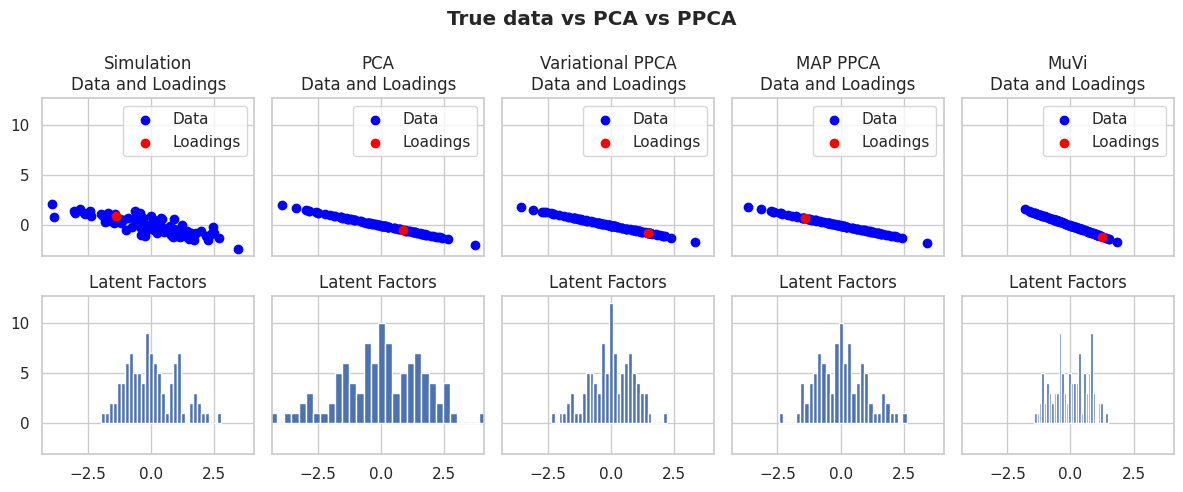

In [24]:
# plot comparison
fig,ax=plt.subplots(2,5,figsize=(12,5),sharex=True,sharey=True)
# fig.suptitle('True data vs PCA vs PPCA', weight='bold')
# true data
data, W_true, Z = generate_ppca_data(n_samples=100, data_dim=2, latent_dim=1, noise_std=0.5)
ax[0,0].scatter(x=data[:,0],y=data[:,1],color='blue',label='Data')
ax[0,0].scatter(x=W_true[0,:],y=W_true[1,:],color='red',label='Loadings')
ax[0,0].legend()
ax[0,0].set_title('Simulation\nData and Loadings')
ax[1,0].hist(Z,bins=30)
ax[1,0].set_title('Latent Factors')
# PCA
pca = PCA(n_components=1)
Z_learned = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_learned@W_learned.transpose() # reconstruct
std_learned = pca.noise_variance_
ax[0,1].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',label='Data')
ax[0,1].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,1].legend()
ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_title('PCA\nData and Loadings')
ax[1,1].hist(Z_learned,bins=30)
ax[1,1].set_title('Latent Factors')
# PPCA Variational Inference
ppca = PPCA_VI(n_components=1, data_dim=2)
# Fit the model
num_steps=3000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
# debug: plot loss
Z_learned = ppca.transform(data)
data_proj = ppca.reconstruct(Z_learned)
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[0,2].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',label='Data')
ax[0,2].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,2].legend()
ax[0,2].set_xlim(ax[0,0].get_xlim())
ax[0,2].set_title('Variational PPCA\nData and Loadings')
ax[1,2].hist(Z_learned,bins=30)
ax[1,2].set_title('Latent Factors')
# PPCA MAP
ppca = PPCA_MAP(n_components=1, data_dim=2)
# Fit the model
num_steps=3000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
# debug: plot loss
Z_learned = ppca.transform(data)
data_proj = ppca.reconstruct(Z_learned)
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[0,3].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',label='Data')
ax[0,3].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,3].legend()
ax[0,3].set_xlim(ax[0,0].get_xlim())
ax[0,3].set_title('MAP PPCA\nData and Loadings')
ax[1,3].hist(Z_learned,bins=30)
ax[1,3].set_title('Latent Factors')
# muvi
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    n_factors=1,
    device=device,
    prior_confidence='low',
    normalize=False,
    reg_hs=True
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_learned = model.get_factor_scores() # factor k in cell i
data_proj = model.get_reconstructed()['dna']
# std_learned = ppca.get_parameters()["noise_variance"]
ax[0,4].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',label='Data')
ax[0,4].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,4].legend()
ax[0,4].set_xlim(ax[0,0].get_xlim())
ax[0,4].set_title('MuVi\nData and Loadings')
ax[1,4].hist(Z_learned,bins=30)
ax[1,4].set_title('Latent Factors')
fig.savefig('muvi_gt.png')
plt.tight_layout()
plt.show()

# Toy Example 2: n clusters in 2d
We can express this system as
$$\begin{pmatrix} 
N(0,\sigma^2)\\ 
N(\Delta,\sigma^2)\end{pmatrix}$$
$$\sim N\left(0,\sigma^2 I\right) + \begin{pmatrix} 0\\
\Delta\end{pmatrix},$$
where any $W=I_2,X\sim N(0,I_2)$ and $\hat\beta=\Delta$ produce the desired results..

In [21]:
# Step 1: Generate synthetic data
def generate_ppca_data(n_samples, data_dim, latent_dim, noise_std, cov = None):
    """
    Generate synthetic data for PPCA.

    Args:
        n_samples (int): Number of data points.
        data_dim (int): Dimensionality of the observed data.
        latent_dim (int): Dimensionality of the latent space.
        noise_std (float): Standard deviation of noise.

    Returns:
        torch.Tensor: Synthetic data matrix (n_samples x data_dim).
    """
    torch.manual_seed(2)  # For reproducibility

    # Generate true latent variables
    Z = torch.randn(n_samples, latent_dim)
    # Generate true loading matrix W
    W_true = torch.randn(data_dim, latent_dim)
    # Generate observed data
    Y = Z @ W_true.T + noise_std * torch.randn(n_samples, data_dim) 
    if cov is not None:
        Y = Y + torch.from_numpy(cov)
    return Y, W_true, Z

/tmp/ipykernel_2273503/2433125620.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors = [color_map[int(xi)] for xi in x]


Step 0 - Loss: 474.5178
Step 500 - Loss: 377.6160
Step 1000 - Loss: 309.6832
Step 1500 - Loss: 287.8178
Step 2000 - Loss: 283.0988
Step 2500 - Loss: 276.0622
Step 0 - Loss: 286.5501
Step 500 - Loss: 271.2457
Step 1000 - Loss: 268.4801
Step 1500 - Loss: 268.4725
Step 2000 - Loss: 268.4724
Step 2500 - Loss: 268.4724


 27%|██▋       | 273/1000 [00:06<00:17, 41.84it/s, ELBO=2.88]


Relative improvement of -0.006155 < 1e-05 for 10 step(s) in a row, stopping early.


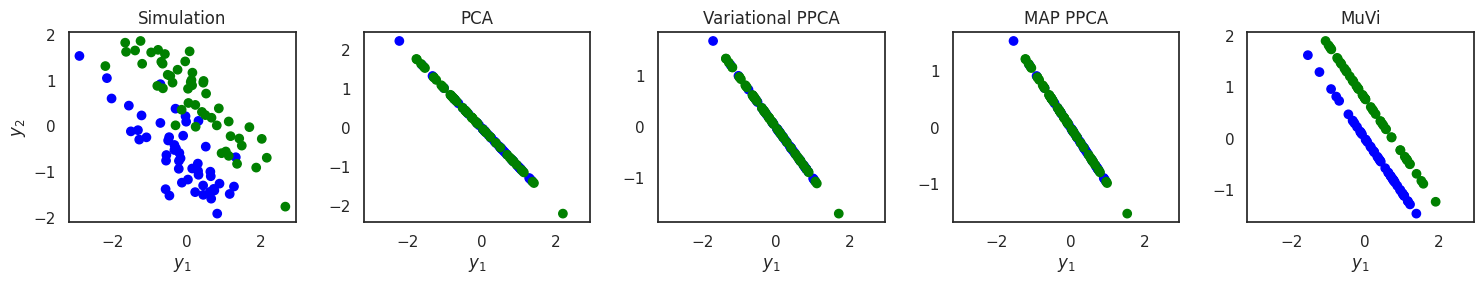

In [24]:
# plot comparison
fig,ax=plt.subplots(1,5,figsize=(15,3),sharex=True,sharey=False)
# fig.suptitle('True data vs PCA vs PPCA', weight='bold')
# true data
Delta = 1 # labels effect
N = 100 # num samples
n = 2 # data dim
p = 1 # latent dim

x = np.concatenate([np.zeros(shape=(N//2,1)),np.ones(shape=(N//2,1))], axis=0)
color_map = ['blue','green','brown']
colors = [color_map[int(xi)] for xi in x]
data, W_true, Z = generate_ppca_data(n_samples=N,
                                     data_dim=n,
                                     latent_dim=p,
                                     noise_std=0.5,
                                     cov = Delta*x)
mu,sd = data.mean(axis=0), data.std(axis=0)
# normalize
data = (data-mu)/sd
ax[0].scatter(x=data[:,0],y=data[:,1],label='Data',c=colors)
# ax[0].scatter(x=W_true[0,:],y=W_true[1,:],color='red',label='Loadings')
# ax[0].legend(loc='lower left')
ax[0].set_xlabel('$y_1$')
ax[0].set_ylabel('$y_2$')
ax[0].set_title('Simulation')

# PCA
pca = PCA(n_components=p)
Z_learned = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_learned@W_learned.transpose() # reconstruct
std_learned = pca.noise_variance_
ax[1].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
# ax[1].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
# ax[1].legend(loc='lower left')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_xlabel('$y_1$')
ax[1].set_title('PCA')
# PPCA Variational Inference
ppca = PPCA_VI(n_components=p, data_dim=n)
# Fit the model
num_steps=3000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
# debug: plot loss
Z_learned = ppca.transform(data)
data_proj = ppca.reconstruct(Z_learned)
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[2].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
# ax[0,2].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
# ax[2].legend(loc='lower left')
ax[2].set_xlabel('$y_1$')
ax[2].set_xlim(ax[0].get_xlim())
ax[2].set_title('Variational PPCA')
# PPCA MAP
ppca = PPCA_MAP(n_components=p, data_dim=n)
# Fit the model
num_steps=3000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
# debug: plot loss
Z_learned = ppca.transform(data.to(torch.float32))
data_proj = ppca.reconstruct(Z_learned)
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[3].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
# ax[0,3].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
# ax[3].legend(loc='lower left')
ax[3].set_xlabel('$y_1$')
ax[3].set_xlim(ax[0].get_xlim())
ax[3].set_title('MAP PPCA')

# muvi
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    covariates=x,
    n_factors=p,
    device=device,
    prior_confidence='low',
    normalize=False,
    reg_hs=True
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_learned = model.get_factor_scores() # factor k in cell i
data_proj = model.get_reconstructed()['dna']
# std_learned = ppca.get_parameters()["noise_variance"]
ax[4].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
# ax[0,4].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
# ax[4].legend(loc='lower left')
ax[4].set_xlim(ax[0].get_xlim())
ax[4].set_xlabel('$y_1$')
ax[4].set_title('MuVi')
plt.tight_layout()
fig.savefig('two_clusters.png',bbox_inches=Bbox([[0,-0.1],fig.get_size_inches()]))
plt.show()

/tmp/ipykernel_903862/3363372118.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors = [color_map[int(xi)] for xi in x]


Step 0 - Loss: 656.4767
Step 500 - Loss: 507.7400
Step 1000 - Loss: 396.8718
Step 1500 - Loss: 332.2619
Step 2000 - Loss: 309.6600
Step 2500 - Loss: 292.0658
Step 0 - Loss: 318.7131
Step 500 - Loss: 278.5468
Step 1000 - Loss: 270.5617
Step 1500 - Loss: 270.3366
Step 2000 - Loss: 270.3296
Step 2500 - Loss: 270.3239


 49%|████▊     | 487/1000 [00:15<00:15, 32.38it/s, ELBO=3.26]


Relative improvement of -0.002932 < 1e-05 for 10 step(s) in a row, stopping early.


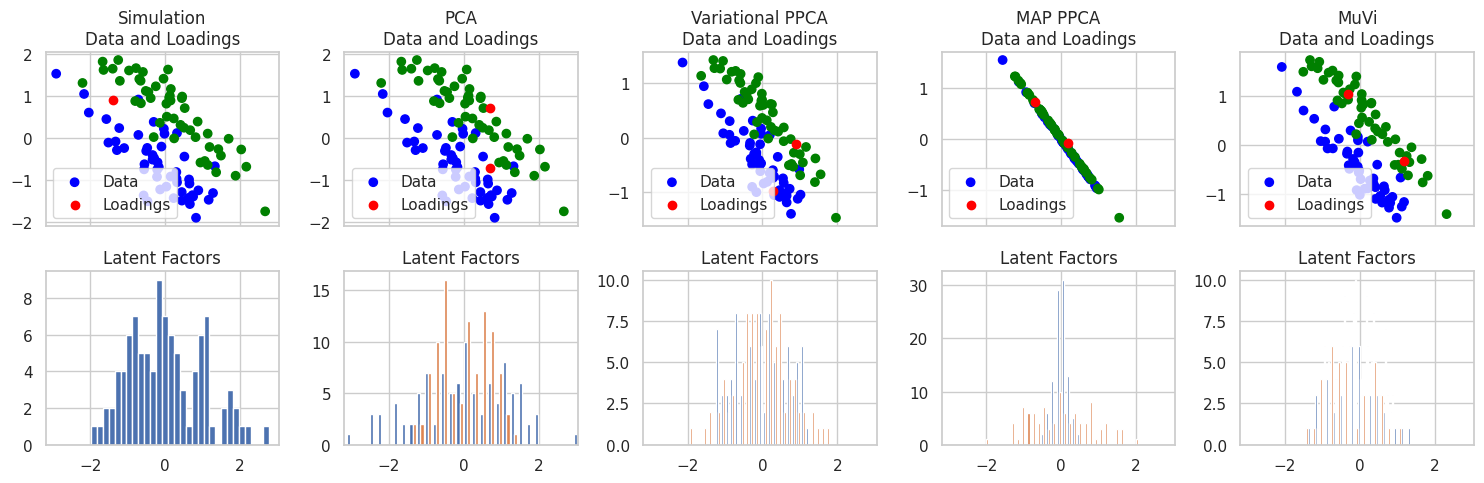

In [13]:
# plot comparison
fig,ax=plt.subplots(2,5,figsize=(15,5),sharex=True,sharey=False)
# true data
Delta = 1 # labels effect
N = 100 # num samples
n = 2 # data dim
p = 1 # latent dim

x = np.concatenate([np.zeros(shape=(N//2,1)),np.ones(shape=(N//2,1))], axis=0)
color_map = ['blue','green','brown']
colors = [color_map[int(xi)] for xi in x]
data, W_true, Z = generate_ppca_data(n_samples=N,
                                     data_dim=n,
                                     latent_dim=p,
                                     noise_std=0.5,
                                     cov = Delta*x)
mu,sd = data.mean(axis=0), data.std(axis=0)
# normalize
data = (data-mu)/sd
ax[0,0].scatter(x=data[:,0],y=data[:,1],label='Data',c=colors)
ax[0,0].scatter(x=W_true[0,:],y=W_true[1,:],color='red',label='Loadings')
ax[0,0].legend(loc='lower left')
ax[0,0].set_title('Simulation\nData and Loadings')
ax[1,0].hist(Z,bins=30)
ax[1,0].set_title('Latent Factors')
# PCA
pca = PCA(n_components=p+1)
Z_learned = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_learned@W_learned.transpose() # reconstruct
std_learned = pca.noise_variance_
ax[0,1].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
ax[0,1].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,1].legend(loc='lower left')
ax[0,1].set_xlim(ax[0,0].get_xlim())
ax[0,1].set_title('PCA\nData and Loadings')
ax[1,1].hist(Z_learned,bins=30)
ax[1,1].set_title('Latent Factors')
# PPCA Variational Inference
ppca = PPCA_VI(n_components=p+1, data_dim=n)
# Fit the model
num_steps=3000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
# debug: plot loss
Z_learned = ppca.transform(data)
data_proj = ppca.reconstruct(Z_learned)
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[0,2].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
ax[0,2].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,2].legend(loc='lower left')
ax[0,2].set_xlim(ax[0,0].get_xlim())
ax[0,2].set_title('Variational PPCA\nData and Loadings')
ax[1,2].hist(Z_learned,bins=30)
ax[1,2].set_title('Latent Factors')
# PPCA MAP
ppca = PPCA_MAP(n_components=p+1, data_dim=n)
# Fit the model
num_steps=3000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
# debug: plot loss
Z_learned = ppca.transform(data.to(torch.float32))
data_proj = ppca.reconstruct(Z_learned)
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[0,3].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
ax[0,3].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,3].legend(loc='lower left')
ax[0,3].set_xlim(ax[0,0].get_xlim())
ax[0,3].set_title('MAP PPCA\nData and Loadings')
ax[1,3].hist(Z_learned,bins=30)
ax[1,3].set_title('Latent Factors')
# muvi
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    covariates=x,
    n_factors=p+1,
    device=device,
    prior_confidence='high',
    normalize=False,
    reg_hs=True
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_learned = model.get_factor_scores() # factor k in cell i
data_proj = model.get_reconstructed()['dna']
# std_learned = ppca.get_parameters()["noise_variance"]
ax[0,4].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
ax[0,4].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[0,4].legend(loc='lower left')
ax[0,4].set_xlim(ax[0,0].get_xlim())
ax[0,4].set_title('MuVi\nData and Loadings')
ax[1,4].hist(Z_learned,bins=30)
ax[1,4].set_title('Latent Factors')
plt.tight_layout()
fig.savefig('two_clusters_p2.png')
plt.show()

/tmp/ipykernel_2273503/2934322104.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors = [color_map[int(xi)] for xi in x]


Step 0 - Loss: 463.6860
Step 500 - Loss: 363.3155
Step 1000 - Loss: 290.4161
Step 1500 - Loss: 265.6911
Step 2000 - Loss: 259.8072
Step 2500 - Loss: 252.8861


 27%|██▋       | 273/1000 [00:06<00:17, 41.59it/s, ELBO=2.88]


Relative improvement of -0.006155 < 1e-05 for 10 step(s) in a row, stopping early.


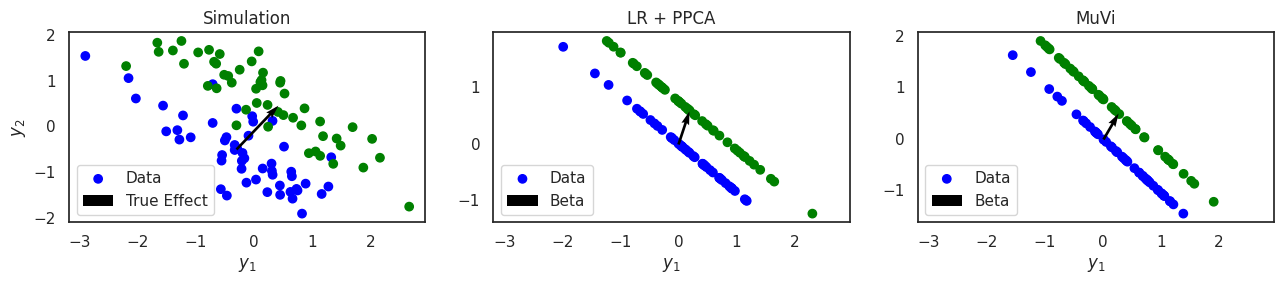

In [26]:
fig,ax=plt.subplots(1,3,figsize=(13,3),sharex=True,sharey=False)
# params
Delta = 1 # labels effect
N = 100 # num samples
n = 2 # data dim
p = 1 # latent dim
# data
x = np.concatenate([np.zeros(shape=(N//2,1)),np.ones(shape=(N//2,1))], axis=0)
color_map = ['blue','green','brown']
colors = [color_map[int(xi)] for xi in x]
data, W_true, Z = generate_ppca_data(n_samples=N,
                                     data_dim=n,
                                     latent_dim=p,
                                     noise_std=0.5,
                                     cov = Delta*x)
mu,sd = data.mean(axis=0), data.std(axis=0)
data = (data-mu)/sd
mu,sd = mu.numpy(),sd.numpy()
ax[0].scatter(x=data[:,0],y=data[:,1],label='Data',c=colors)
# ax[0,0].scatter(x=W_true[0,:],y=W_true[1,:],color='red',label='Loadings')
ax[0].quiver(*-mu/sd,*(np.array([Delta,Delta])-mu)/sd, angles='xy', scale_units='xy', scale=0.5, color=['black'], label='True Effect')
ax[0].legend(loc='lower left')
ax[0].set_xlabel('$y_1$')
ax[0].set_ylabel('$y_2$')
ax[0].set_title('Simulation')
# LR + PPCA
lreg = sm.OLS(data.numpy(),x)
results = lreg.fit()
beta_hat = results.params[0]
r_hat = results.resid
y_hat = results.predict(x)
# PPCA Variational Inference
ppca = PPCA_VI(n_components=p, data_dim=n)
# Fit the model
num_steps=3000
losses = ppca.fit(torch.from_numpy(r_hat),num_steps=num_steps,lr=1e-3)
# debug: plot loss
# plt.figure(figsize=(5,3))
# plt.plot(np.arange(len(losses)),losses)
# plt.title(f'Loss after {num_steps} epochs')
# plt.show()
Z_learned = ppca.transform(torch.from_numpy(r_hat))
data_proj = ppca.reconstruct(Z_learned) # esimated residual
data_proj = data_proj + y_hat
W_learned = ppca.get_parameters()["W"]
std_learned = ppca.get_parameters()["noise_variance"]
ax[1].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
# ax[0,1].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[1].quiver(0,0,*beta_hat, angles='xy', scale_units='xy', scale=1, color=['black'],label='Beta')
ax[1].legend(loc='lower left')
ax[1].set_title('LR + PPCA')
ax[1].set_xlabel('$y_1$')
# MuVi
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    covariates=x,
    n_factors=p,
    device=device,
    prior_confidence='high',
    normalize=False,
    reg_hs=True
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_learned = model.get_factor_scores() # factor k in cell i
data_proj = model.get_reconstructed()['dna'] 
beta_learned = model.get_covariate_coefficients()['dna'][0]
ax[2].scatter(x=data_proj[:,0],y=data_proj[:,1],label='Data',c=colors)
# ax[0,2].scatter(x=W_learned[0,:],y=W_learned[1,:],color='red',label='Loadings')
ax[2].quiver(0,0,*beta_learned, angles='xy', scale_units='xy', scale=1, color=['black'],label='Beta')
ax[2].legend(loc='lower left')
ax[2].set_title('MuVi')
ax[2].set_xlabel('$y_1$')
plt.tight_layout()
fig.savefig('lr_ppca_clusters.png')
plt.show()

# High dimensional data

In [13]:
from scipy.stats import gaussian_kde
from matplotlib.transforms import Bbox
from matplotlib import cm

In [5]:
data, W_true, Z = generate_ppca_data(n_samples=100, data_dim=50, latent_dim=2, noise_std=0.5)
# PCA
pca = PCA(n_components=2)
Z_learned = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_learned@W_learned.transpose() # reconstruct

In [6]:
data_proj.shape

(100, 50)

Step 0 - Loss: 36795.6084
Step 500 - Loss: 31611.8975
Step 1000 - Loss: 25494.8172
Step 1500 - Loss: 19820.8444
Step 2000 - Loss: 17318.8485
Step 2500 - Loss: 16480.9386
Step 3000 - Loss: 16360.1513
Step 3500 - Loss: 16308.5684
Step 4000 - Loss: 16294.1300
Step 4500 - Loss: 16293.0177
Step 5000 - Loss: 16281.7538
Step 5500 - Loss: 16278.0794
Step 0 - Loss: 37496.3633
Step 500 - Loss: 32251.5996
Step 1000 - Loss: 27039.4883
Step 1500 - Loss: 19748.8418
Step 2000 - Loss: 16024.1465
Step 2500 - Loss: 15433.9736
Step 3000 - Loss: 15397.1396
Step 3500 - Loss: 15393.5732
Step 4000 - Loss: 15390.9365
Step 4500 - Loss: 15388.9629
Step 5000 - Loss: 15387.8018
Step 5500 - Loss: 15387.3047


 35%|███▌      | 704/2000 [00:15<00:27, 46.76it/s, ELBO=174]


Relative improvement of -0.0003286 < 1e-05 for 10 step(s) in a row, stopping early.


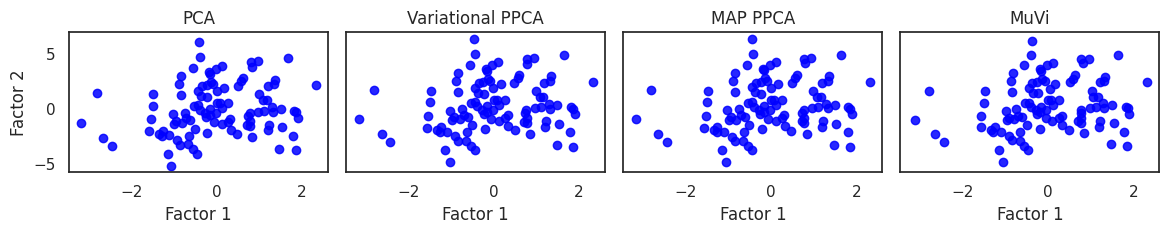

In [17]:
# plot comparison
sns.set_style("white")
fig,ax=plt.subplots(1,4,figsize=(12,2.5),sharex=True,sharey=True)
# fig.suptitle('Reconstructed Data', weight='bold')
# true data
N=100
n=200
p=2
data, W_true, Z = generate_ppca_data(n_samples=N, data_dim=n, latent_dim=p, noise_std=0.5)
# PCA
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_pca@W_learned.transpose() # reconstruct
std_pca = pca.noise_variance_
ax[0].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',alpha=0.85)
ax[0].set_xlabel('Factor 1')
ax[0].set_ylabel('Factor 2')
ax[0].set_title('PCA')
# # PPCA Variational Inference
ppca = PPCA_VI(n_components=p, data_dim=n)
# # Fit the model
num_steps=6000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
Z_vi = ppca.transform(data)
data_proj = ppca.reconstruct(Z_vi)
W_learned = ppca.get_parameters()["W"]
std_vi = ppca.get_parameters()["noise_variance"]
ax[1].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',alpha=0.85)
ax[1].set_title('Variational PPCA')
ax[1].set_xlabel('Factor 1')
# # PPCA MAP
ppca = PPCA_MAP(n_components=p, data_dim=n)
# # Fit the model
num_steps=6000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
Z_map = ppca.transform(data.to(torch.float32))
data_proj = ppca.reconstruct(Z_map)
W_learned = ppca.get_parameters()["W"]
std_map = ppca.get_parameters()["noise_variance"]
ax[2].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',alpha=0.85)
ax[2].set_title('MAP PPCA')
ax[2].set_xlabel('Factor 1')
# # muvi
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    n_factors=p,
    device=device,
    prior_confidence='low',
    normalize=False,
    reg_hs=True
)
max_iter = 2000
model.fit(seed=0,n_epochs=max_iter)
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_muvi = model.get_factor_scores() # factor k in cell i
data_proj = Z_muvi@W_learned.transpose() # reconstruct
std_muvi = ppca.get_parameters()["noise_variance"]
ax[3].scatter(x=data_proj[:,0],y=data_proj[:,1],color='blue',alpha=0.85)
ax[3].set_title('MuVi')
ax[3].set_xlabel('Factor 1')
fig.savefig('hd_data_reco.png',bbox_inches=Bbox([[0,-0.5],fig.get_size_inches()]))
plt.tight_layout()
plt.show()

In [18]:
std_pca,std_vi,std_map,std_muvi

(0.492822928537414, tensor(0.2481), tensor(0.2439), tensor(0.2439))

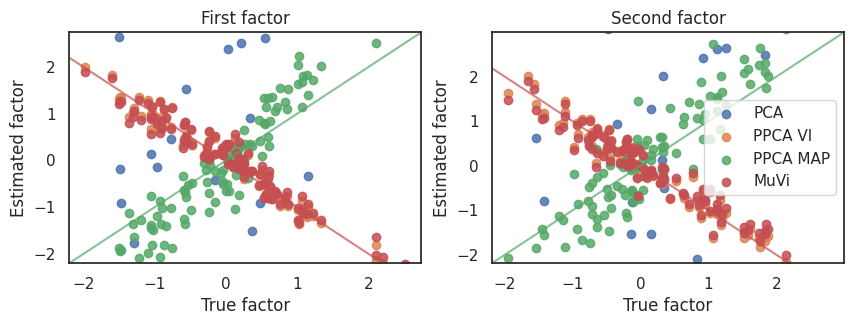

In [19]:
sns.set_style("white")
fig,ax = plt.subplots(1,2,figsize=(10,3),sharex=False,sharey=False)
ax[0].set_title('First factor')
ax[0].set_xlabel('True factor')
ax[0].set_ylabel('Estimated factor')
ax[0].scatter(x=Z[:,0],y=Z_pca[:,0],label='PCA',alpha=0.85)
ax[0].scatter(x=Z[:,0],y=Z_vi[:,0],label='PPCA VI',alpha=0.85)
ax[0].scatter(x=Z[:,0],y=Z_map[:,0],label='PPCA MAP',alpha=0.85)
ax[0].scatter(x=Z[:,0],y=Z_muvi[:,0],label='MuVi',alpha=0.85)
ax[0].set_ylim(ax[0].get_xlim())
ax[0].axline((0, 0), slope=-1, color='r',alpha=0.7)
ax[0].axline((0, 0), slope=1, color='g',alpha=0.7)
# ax[0].legend()

ax[1].set_title('Second factor')
ax[1].set_xlabel('True factor')
ax[1].set_ylabel('Estimated factor')
ax[1].scatter(x=Z[:,1],y=Z_pca[:,1],label='PCA',alpha=0.85)
ax[1].scatter(x=Z[:,1],y=Z_vi[:,1],label='PPCA VI',alpha=0.85)
ax[1].scatter(x=Z[:,1],y=Z_map[:,1],label='PPCA MAP',alpha=0.85)
ax[1].scatter(x=Z[:,1],y=Z_muvi[:,1],label='MuVi',alpha=0.85)
ax[1].set_ylim(ax[1].get_xlim())
ax[1].axline((0, 0), slope=-1, color='r',alpha=0.7)
ax[1].axline((0, 0), slope=1, color='g',alpha=0.7)
ax[1].legend()
fig.savefig('hd_latents.png',bbox_inches=Bbox([[0,-0.5],fig.get_size_inches()]))
plt.show()

/tmp/ipykernel_1997097/3558647118.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  colors = [color_map[int(xi)] for xi in x]


Step 0 - Loss: 29441.5574
Step 500 - Loss: 24737.2016
Step 1000 - Loss: 19465.6061
Step 1500 - Loss: 17111.9769
Step 2000 - Loss: 16959.0562
Step 2500 - Loss: 16745.4389
Step 3000 - Loss: 16739.5449
Step 3500 - Loss: 16725.4778
Step 4000 - Loss: 16725.9918
Step 4500 - Loss: 16733.0540
Step 5000 - Loss: 16723.2586
Step 5500 - Loss: 16726.1510
Step 0 - Loss: 29399.5508
Step 500 - Loss: 26599.4473
Step 1000 - Loss: 21345.9355
Step 1500 - Loss: 17358.4688
Step 2000 - Loss: 16096.1816
Step 2500 - Loss: 15954.9863
Step 3000 - Loss: 15942.5469
Step 3500 - Loss: 15935.8750
Step 4000 - Loss: 15930.6650
Step 4500 - Loss: 15927.5811
Step 5000 - Loss: 15926.3896
Step 5500 - Loss: 15926.1201


 24%|██▍       | 486/2000 [00:10<00:33, 45.50it/s, ELBO=102]


Relative improvement of -0.0008843 < 1e-05 for 10 step(s) in a row, stopping early.


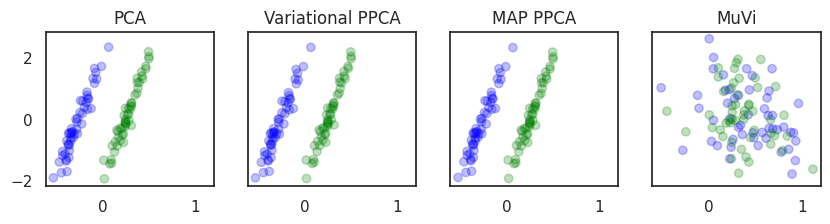

In [132]:
# plot comparison
# true data Delta 1.5, noise = 0.5 will make ONLY muvi fail
Delta = 1.5 # labels effect
N = 100 # num samples
n = 200 # data dim
p = 2 # latent dim
x = np.concatenate([np.zeros(shape=(N//2,1)),np.ones(shape=(N//2,1))], axis=0)
color_map = ['blue','green','brown']
colors = [color_map[int(xi)] for xi in x]
data, W_true, Z = generate_ppca_data(n_samples=N,
                                     data_dim=n,
                                     latent_dim=p,
                                     noise_std=0.15,
                                     cov = Delta*x)
mu,sd = data.mean(axis=0), data.std(axis=0)
# normalize
data = (data-mu)/sd
# plot comparison
fig,ax=plt.subplots(1,4,figsize=(10,2),sharex=True,sharey=True)
# true data
# PCA
pca = PCA(n_components=p)
Z_pca = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_pca@W_learned.transpose() # reconstruct
std_pca = pca.noise_variance_
sns.set_style("white")
ax[0].scatter(x=data_proj[:,0],y=data_proj[:,1],alpha=0.45,c=colors)
ax[0].set_title('PCA')
# # PPCA Variational Inference
ppca = PPCA_VI(n_components=p, data_dim=n)
# # Fit the model
num_steps=6000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
Z_vi = ppca.transform(data)
data_proj = ppca.reconstruct(Z_vi)
W_learned = ppca.get_parameters()["W"]
std_vi = ppca.get_parameters()["noise_variance"]
ax[1].scatter(x=data_proj[:,0],y=data_proj[:,1],alpha=0.45,c=colors)
ax[1].set_title('Variational PPCA')
# # PPCA MAP
ppca = PPCA_MAP(n_components=p, data_dim=n)
# # Fit the model
num_steps=6000
losses = ppca.fit(data,num_steps=num_steps,lr=1e-3)
Z_map = ppca.transform(data.to(torch.float32))
data_proj = ppca.reconstruct(Z_map)
W_learned = ppca.get_parameters()["W"]
std_map = ppca.get_parameters()["noise_variance"]
ax[2].scatter(x=data_proj[:,0],y=data_proj[:,1],alpha=0.45,c=colors)
ax[2].set_title('MAP PPCA')
ax[2].set_xlabel('Factor 1')
# # muvi
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    n_factors=p,
    device=device,
    prior_confidence='low',
    normalize=False,
    reg_hs=True,
    covariates=x
)
max_iter = 2000
model.fit(seed=0,n_epochs=max_iter)
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_muvi = model.get_factor_scores() # factor k in cell i
data_proj = model.get_reconstructed()['dna'] # reconstruct
std_muvi = ppca.get_parameters()["noise_variance"]
ax[3].scatter(x=data_proj[:,0],y=data_proj[:,1],alpha=0.45,c=colors)
ax[3].set_title('MuVi')
ax[3].set_xlabel('Factor 1')
fig.savefig('hd_two_clusters.png')
plt.show()

# Extra

# Variational PPCA

In [4]:
# Parameters for synthetic data
n_samples = 100
data_dim = 100
latent_dim = 2
noise_std = 0.05

# Generate data
data, W_true, Z = generate_ppca_data(n_samples, data_dim, latent_dim, noise_std)
mu, sd = data.mean(dim=0),data.std(dim=0)
# data = (data-mu) / sd

Step 0 - Loss: 14946.8316
Step 500 - Loss: 11600.0189
Step 1000 - Loss: 7093.9366
Step 1500 - Loss: 4214.9057
Step 2000 - Loss: 1458.1033
Step 2500 - Loss: 65.1315
Step 3000 - Loss: -2296.7627
Step 3500 - Loss: -4122.5585
Step 4000 - Loss: -5372.9260
Step 4500 - Loss: -6676.8812
Step 5000 - Loss: -6946.7596
Step 5500 - Loss: -7047.3536


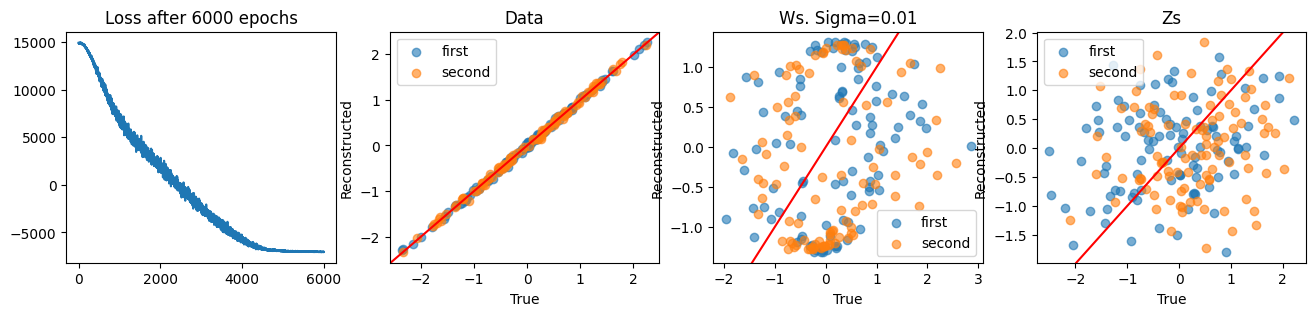

In [5]:
# true dimension 2, latent dimension 2
W_hat,Z_hat,y_hat = ppca_analysis(PPCA_VI, latent_dim, data, W_true, Z, lr=1e-3, num_steps=6000)

# MAP PPCA

Step 0 - Loss: 14662.1387
Step 500 - Loss: 11775.5889
Step 1000 - Loss: 4390.0381
Step 1500 - Loss: -2016.1428
Step 2000 - Loss: -4975.6890


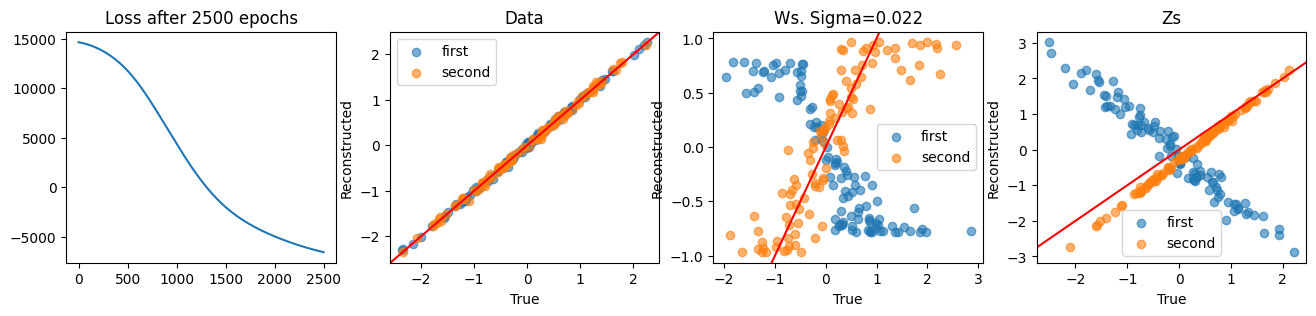

In [6]:
W_map,Z_map,y_map = ppca_analysis(PPCA_MAP, latent_dim,data,W_true,Z,lr=1e-3,num_steps=2500)

In [ ]:
W_map

In [26]:
# pyro.render_model(
#     ppca.model, model_args=(data,), render_distributions=True
# )

# Deterministic PCA

In [15]:
data.shape

torch.Size([100, 100])

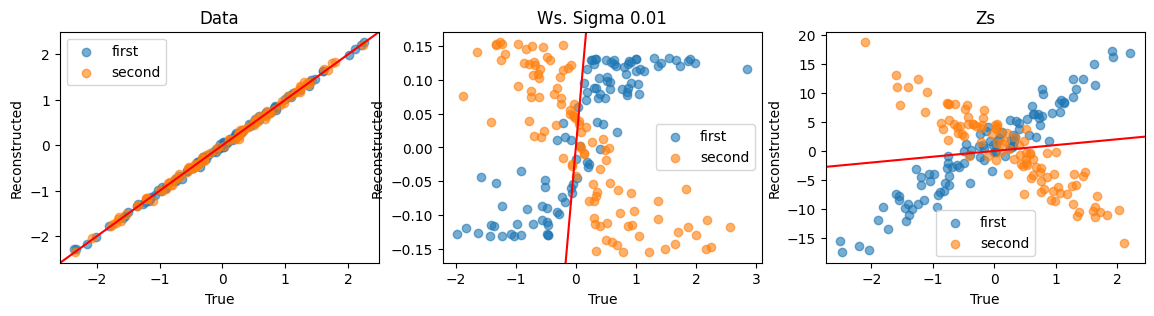

In [7]:
pca = PCA(n_components=latent_dim)
# Fit the model
# Transform the data to the latent space
Z_learned = pca.fit_transform(data)
W_learned = pca.components_.transpose()
data_proj = Z_learned@W_learned.transpose() # reconstruct
std_learned = pca.noise_variance_
fig,ax = plt.subplots(1,3,figsize=(14,3))
# Step 4: Visualize the results
# Plot the true vs. reconstructed data for the first feature
# Plot the true vs. reconstructed data for the first feature
ax[0].scatter(data[:, 0].detach().numpy(), data_proj[:, 0], alpha=0.6,label='first')
ax[0].scatter(data[:, 1].detach().numpy(), data_proj[:, 1], alpha=0.6,label='second')
ax[0].legend()
ax[0].axline((0, 0), slope=1, color='r')
ax[0].set_xlabel("True")
ax[0].set_ylabel("Reconstructed")
ax[0].set_title("Data")

# Compare true and learned loading matrices
ax[1].scatter(W_true[:, 0].detach().numpy(), W_learned[:, 0], alpha=0.6,label='first')
ax[1].scatter(W_true[:, 1].detach().numpy(), W_learned[:, 1], alpha=0.6,label='second')
ax[1].legend()
ax[1].axline((0, 0), slope=1, color='r')
ax[1].set_xlabel("True")
ax[1].set_ylabel("Reconstructed")
ax[1].set_title(f"Ws. Sigma {round(pca.noise_variance_,3)}")

# compare hidden variables
ax[2].scatter(Z[:, 0].detach().numpy(), Z_learned[:, 0], alpha=0.6,label='first')
ax[2].scatter(Z[:, 1].detach().numpy(), Z_learned[:, 1], alpha=0.6,label='second')
ax[2].legend()
ax[2].axline((0, 0), slope=1, color='r')
ax[2].set_xlabel("True")
ax[2].set_ylabel("Reconstructed")
ax[2].set_title("Zs")
plt.show()

In [8]:
W_learned.transpose()@W_learned


array([[ 1.00000000e+00, -5.32938614e-17],
       [-5.32938614e-17,  1.00000000e+00]])

In [9]:
pca.singular_values_

array([75.58898187, 63.96613605])

# MUVI

In [12]:
model = muvi_2.MuVI(
    observations={"dna": data.numpy()}, # single view
    n_factors=2,
    device=device,
    prior_confidence='low',
    normalize=False,
    reg_hs=True
)
max_iter = 1000
model.fit(seed=0,n_epochs=max_iter)

 86%|████████▌ | 859/1000 [00:20<00:03, 42.91it/s, ELBO=-75.1] 


Relative improvement of -0.005338 < 1e-05 for 10 step(s) in a row, stopping early.


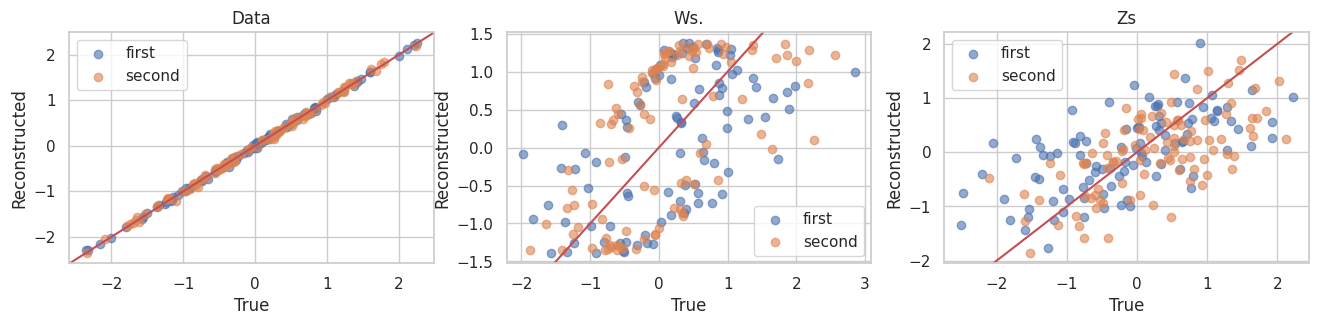

In [13]:
fig,ax = plt.subplots(1,3,figsize=(16,3))
# Retrieve learned parameters
W_learned = model.get_factor_loadings()['dna'].transpose()
Z_learned = model.get_factor_scores() # factor k in cell i
data_proj = model.get_reconstructed()['dna']
# factor_scales = model._guide.get_factor_scale() # delta of factor k
# factor_scales = factor_scales / np.max(factor_scales, axis=1)[:, None]
# sns.heatmap(factor_scales,annot=True)

# Plot the true vs. reconstructed data for the first feature
ax[0].scatter(data[:, 0].detach().numpy(), data_proj[:, 0], alpha=0.6,label='first')
ax[0].scatter(data[:, 1].detach().numpy(), data_proj[:, 1], alpha=0.6,label='second')
ax[0].legend()
ax[0].axline((0, 0), slope=1, color='r')
ax[0].set_xlabel("True")
ax[0].set_ylabel("Reconstructed")
ax[0].set_title("Data")

# Compare true and learned loading matrices
ax[1].scatter(W_true[:, 0].detach().numpy(), W_learned[:, 0], alpha=0.6,label='first')
ax[1].scatter(W_true[:, 1].detach().numpy(), W_learned[:, 1], alpha=0.6,label='second')
ax[1].legend()
ax[1].axline((0, 0), slope=1, color='r')
ax[1].set_xlabel("True")
ax[1].set_ylabel("Reconstructed")
ax[1].set_title(f"Ws.")# Sigma={round(std_learned.item(),3)}")

# compare hidden variables
ax[2].scatter(Z[:, 0].detach().numpy(), Z_learned[:, 0], alpha=0.6,label='first')
ax[2].scatter(Z[:, 1].detach().numpy(), Z_learned[:, 1], alpha=0.6,label='second')
ax[2].legend()
ax[2].axline((0, 0), slope=1, color='r')
ax[2].set_xlabel("True")
ax[2].set_ylabel("Reconstructed")
ax[2].set_title("Zs")
plt.show()

In [14]:
model._guide.get_sigma()

array([[0.1001083 , 0.11080259, 0.10632543, 0.10807224, 0.12242462,
        0.10154504, 0.13040118, 0.11166953, 0.12955433, 0.10652467,
        0.11127184, 0.23378414, 0.10176823, 0.10522146, 0.10907881,
        0.14503178, 0.11256557, 0.6235899 , 0.10810619, 0.12358869,
        0.10389042, 0.10352174, 0.11058044, 0.11584438, 0.10954931,
        0.1008368 , 0.11472824, 0.1835629 , 0.10318811, 0.11841056,
        0.12403291, 0.10618094, 0.10616168, 0.10404574, 0.10594878,
        0.16187425, 0.11702702, 0.11555441, 0.18084395, 0.11278091,
        0.11220957, 0.1263376 , 0.1087434 , 0.10975689, 0.1278115 ,
        0.10438468, 0.11267824, 0.11684465, 0.11633163, 0.101709  ,
        0.10817131, 0.10887877, 0.11248948, 0.0989411 , 0.10093034,
        0.10730427, 0.12337583, 0.10913443, 0.11108509, 0.13526128,
        0.11461506, 0.09754253, 0.157601  , 0.10254975, 0.14802414,
        0.10554369, 0.11401059, 0.10801176, 0.11985803, 0.24599846,
        0.12209652, 0.10860641, 0.10282082, 0.13

In [ ]:
# Init PPCA model
def ppca_analysis(ppca_model,data,lr,num_steps):
    ppca = ppca_model(n_components=latent_dim, data_dim=data_dim)
    # Fit the model
    losses = ppca.fit(data,num_steps=num_steps,lr=lr)
    
    fig,ax = plt.subplots(1,3,figsize=(16,3))
    ax[0].plot(np.arange(len(losses)),losses)
    ax[0].set_title(f'Loss after {num_steps} epochs')
    # plt.show()

    # Analyze the results
    # Transform the data to the latent space
    Z_learned = ppca.transform(data)

    # Reconstruct the data from the latent representation
    data_proj = ppca.reconstruct(Z_learned)

    # Retrieve learned parameters
    parameters = ppca.get_parameters()
    W_learned,std_learned = parameters["W"],parameters["noise_variance"]

    # Step 4: Visualize the results
    # Plot the true vs. reconstructed data for the first feature
    ax[1].scatter(data[:, 0].detach().numpy(), data_proj[:, 0].detach().numpy(), alpha=0.6,label='first')
    ax[1].scatter(data[:, 1].detach().numpy(), data_proj[:, 1].detach().numpy(), alpha=0.6,label='second')
    ax[1].legend()
    ax[1].set_xlabel("True")
    ax[1].set_ylabel("Reconstructed")
    ax[1].set_title("Data")


In [ ]:
# define centers of normals
cells,genes = (10,100)
taus = generate_centers(n=2,genes=genes,a=0,b=5)
# generate data
y,labels = generate_data(size=(cells,genes), taus = taus)
mu,sd = y.mean(axis=0), y.std(axis=0)
# normalize
y = (y-mu)/sd
# visualize first column of data. Should look like N normals
fig,ax = plt.subplots(1,3,figsize=(15,4))
i = 0
ax[0].hist(y[:,i],bins=15)
ax[0].set_title(f'Distribution of Normalized Feature {i+1}')
# plt.show()
# compute PCA
n_components = len(taus)
pca = PCA(n_components=n_components)
y_proj = pca.fit_transform(y)
# plot data on first 2 components
ax[1].scatter(y_proj[:,0],y_proj[:,1],c = labels)
ax[1].set_title('Projection on first 2 Principal Components')
# plt.show()
# Compute % of var explained
ax[2].bar(x = np.arange(n_components),height = pca.explained_variance_ratio_)
addlabels(x=np.arange(n_components),y=pca.explained_variance_ratio_)
ax[2].set_title(f'Variance explained by {n_components} components: {round(100*sum(pca.explained_variance_ratio_),1)} %')
plt.show()